In [1833]:
import pandas as pd
import talib
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split


In [1834]:
WINDOW_MA = 10 #10 MEJOR VALOR 
WINDOW_RSI = 10 #10 MEJOR VALOR 
SLIDING_WINDOW = 5 #5 MEJOR VALOR 
EPSILON_TOLERANCE = 0.30 # 0.30 MEJOR VALOR

Lectura de archivos

In [1835]:
tweets_df = pd.read_csv("../data/tweets_with_sentiment_cryptobert.csv")
price_df = pd.read_csv("../data/data_binance.csv")
tweets_df['fecha'] = pd.to_datetime(tweets_df['Created At'], errors='coerce')
# Asigna dia, mes y año a la nueva columna fecha quitando la hora
tweets_df['fecha'] = tweets_df['fecha'].dt.date
price_df['fecha'] = pd.to_datetime(price_df['fecha'], errors='coerce')

In [1836]:
# We count by kind of feeling
count_sentiment = tweets_df.groupby(['fecha', 'Sentiment']).size().unstack(fill_value=0)

# We recalculate totals and average
count_sentiment['numero_noticias'] = count_sentiment.sum(axis=1)
count_sentiment['promedio_sentimiento'] = tweets_df.groupby('fecha')['Sentiment'].mean()

Transforma las columnas date en formato datetime.date

In [1837]:
price_df['fecha'] = pd.to_datetime(price_df['fecha']).dt.date 
count_sentiment = count_sentiment.reset_index()  # si 'fecha' está en el índice
count_sentiment['fecha'] = pd.to_datetime(count_sentiment['fecha']).dt.date
count_sentiment.rename(
    columns={
        -1:'negative_sentiment_news',
        0:'neutral_sentiment_news',
        1:'positive_sentiment_news'
    },
    inplace=True
)


Realiza la fusión de los dos DataFrames (price_df y conteo_sentimientos) usando la columna fecha como clave



In [1838]:
# We join by date
df_final = price_df.merge(count_sentiment, on='fecha', how='left')

CALCULO MEDIA MOVIL CON DERIVADA Y TENDENCIA

In [1839]:

# We added trend column
df_final['media_movil_10d'] = df_final['precio_apertura'].rolling(WINDOW_MA).mean()
df_final['mm10_smooth'] = savgol_filter(df_final['media_movil_10d'], WINDOW_MA+1, polyorder=2)
df_final['derivada_mm10'] = np.gradient(df_final['mm10_smooth'])



In [1840]:
epsilon = df_final['derivada_mm10'].std() * EPSILON_TOLERANCE
condition_list = [
    df_final['derivada_mm10'].isna() | ((df_final['derivada_mm10'] > -epsilon) & (df_final['derivada_mm10'] < epsilon)),
    df_final['derivada_mm10'] > 0,
    df_final['derivada_mm10'] < 0,
]
returns_values_list = [0, 1, -1]
df_final['tendencia_categorizada'] = np.select(condition_list, returns_values_list, 0)

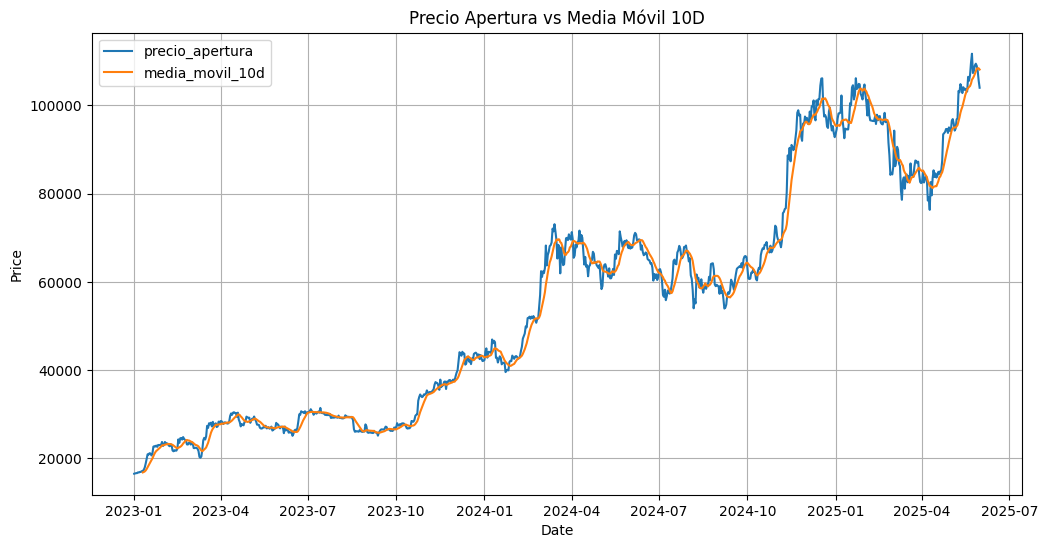

In [1841]:
# Grafico precio apertura vs media movil 10d
df_temp = df_final.copy()
df_temp.set_index('fecha', inplace=True)
df_temp[['precio_apertura', 'media_movil_10d']].plot(figsize=(12,6), title='Precio Apertura vs Media Móvil 10D', grid=True)
plt.ylabel('Price')
plt.xlabel('Date')
plt.show()


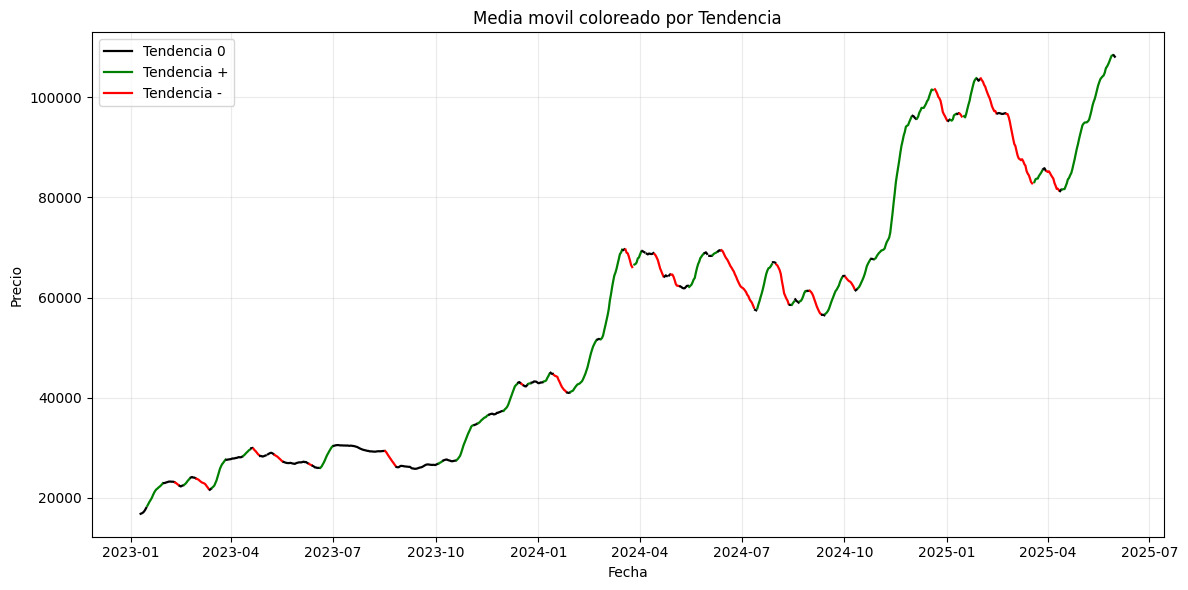

In [1842]:
import itertools

# Data para graficar
df_plot = df_final[['fecha','media_movil_10d','tendencia_categorizada']].dropna().copy()
df_plot = df_plot.sort_values('fecha').set_index('fecha')

fig, ax = plt.subplots(figsize=(12,6))
colors = {1:'green', 0:'black', -1:'red'}

first_label_done = set()

# Agrupar tramos consecutivos con misma tendencia
for trend, group in itertools.groupby(zip(df_plot.index, df_plot['tendencia_categorizada']), key=lambda x: x[1]):
    group_list = list(group)
    idxs = [ts for ts,_ in group_list]
    prices = df_plot.loc[idxs, 'media_movil_10d']
    label = None
    if trend not in first_label_done:
        label = {1:'Tendencia +',0:'Tendencia 0',-1:'Tendencia -'}[trend]
        first_label_done.add(trend)
    ax.plot(prices.index, prices.values, color=colors[trend], linewidth=1.6, label=label)

ax.set_title('Media movil coloreado por Tendencia')
ax.set_ylabel('Precio')
ax.set_xlabel('Fecha')
ax.legend(loc='upper left')
ax.grid(alpha=0.25)

plt.tight_layout()
plt.show()
#

📈 Indicador RSI (Relative Strength Index)

📊 RSI toma valores entre 0 y 100:

- (<30) podría indicar sobreventa.
- (>70) podría indicar sobrecompra.

In [1843]:
# PROFE TIPS: trata de no usar funciones creadas por ti para los indicadores
# LISTO CORREGIDO

df_final['RSI_10'] = talib.RSI(df_final['precio_apertura'], WINDOW_RSI)

🔁 Indicador MACD (Moving Average Convergence Divergence)


In [1844]:
# EMA rápida y lenta
ema_12 = df_final['precio_apertura'].ewm(span=12, adjust=False).mean()
ema_26 = df_final['precio_apertura'].ewm(span=26, adjust=False).mean()

# Línea MACD y señal
df_final['MACD'] = ema_12 - ema_26
df_final['MACD_signal'] = df_final['MACD'].ewm(span=9, adjust=False).mean()

In [1845]:
df_final

,simbolo,fecha,precio_apertura,precio_maximo,precio_minimo,precio_cierre,volumen,negative_sentiment_news,neutral_sentiment_news,positive_sentiment_news,numero_noticias,promedio_sentimiento,media_movil_10d,mm10_smooth,derivada_mm10,tendencia_categorizada,RSI_10,MACD,MACD_signal
0,BTCUSDT,2023-01-01,16541.77,16628.00,16499.01,16616.75,96925.41374,0,10,5,15,0.333333,NaN,NaN,NaN,0,NaN,0.000000,0.000000
1,BTCUSDT,2023-01-02,16617.17,16799.23,16548.70,16672.87,121888.57191,0,2,0,2,0.000000,NaN,NaN,NaN,0,NaN,6.014815,1.202963
2,BTCUSDT,2023-01-03,16672.78,16778.40,16605.28,16675.18,159541.53733,0,5,3,8,0.375000,NaN,NaN,NaN,0,NaN,15.094857,3.981342
3,BTCUSDT,2023-01-04,16675.65,16991.87,16652.66,16850.36,220362.18862,2,4,5,11,0.272727,NaN,NaN,NaN,0,NaN,22.265775,7.638228
4,BTCUSDT,2023-01-05,16850.36,16879.82,16753.00,16831.85,163473.56641,1,6,6,13,0.384615,NaN,NaN,NaN,0,NaN,41.567254,14.424034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,BTCUSDT,2025-05-27,109434.78,110718.00,107516.57,108938.17,21276.65635,1,10,8,19,0.368421,107686.404,107646.127074,339.913637,1,66.138775,3769.126180,3868.602046
878,BTCUSDT,2025-05-28,108938.17,109284.70,106769.43,107781.78,15633.78829,2,24,13,39,0.282051,108267.556,107948.184134,264.200483,1,63.750214,3639.414671,3822.764571
879,BTCUSDT,2025-05-29,107781.78,108891.91,105322.86,105589.75,19834.70116,7,25,13,45,0.133333,108400.307,108174.528041,188.487329,1,58.302505,3404.066398,3739.024936
880,BTCUSDT,2025-05-30,105589.75,106313.12,103621.00,103985.48,23706.49799,0,16,6,22,0.272727,108401.909,108325.158793,112.774176,0,49.409607,3006.021155,3592.424180


Creación df con indicadores finales

In [1846]:
# Selecting final columns
df_csv = df_final[['fecha',
                    'precio_apertura',
                    'media_movil_10d', 
                    'RSI_10', 
                    'MACD_signal', 
                    'tendencia_categorizada', 
                    'numero_noticias', 
                    'negative_sentiment_news', 
                    'neutral_sentiment_news', 
                    'positive_sentiment_news', 
                    'promedio_sentimiento']]

# We rename columns
df_csv.columns = ['date', 
                  'open',
                  'MA',
                  'RSI',
                  'MACD', 
                  'trend', 
                  'issue_news', 
                  'negative_sentiment_news', 
                  'neutral_sentiment_news', 
                  'positive_sentiment_news', 
                  'average_news']



In [1847]:
df_final.head(5)

,simbolo,fecha,precio_apertura,precio_maximo,precio_minimo,precio_cierre,volumen,negative_sentiment_news,neutral_sentiment_news,positive_sentiment_news,numero_noticias,promedio_sentimiento,media_movil_10d,mm10_smooth,derivada_mm10,tendencia_categorizada,RSI_10,MACD,MACD_signal
0,BTCUSDT,2023-01-01,16541.77,16628.00,16499.01,16616.75,96925.41374,0,10,5,15,0.333333,NaN,NaN,NaN,0,NaN,0.000000,0.000000
1,BTCUSDT,2023-01-02,16617.17,16799.23,16548.70,16672.87,121888.57191,0,2,0,2,0.000000,NaN,NaN,NaN,0,NaN,6.014815,1.202963
2,BTCUSDT,2023-01-03,16672.78,16778.40,16605.28,16675.18,159541.53733,0,5,3,8,0.375000,NaN,NaN,NaN,0,NaN,15.094857,3.981342
3,BTCUSDT,2023-01-04,16675.65,16991.87,16652.66,16850.36,220362.18862,2,4,5,11,0.272727,NaN,NaN,NaN,0,NaN,22.265775,7.638228
4,BTCUSDT,2023-01-05,16850.36,16879.82,16753.00,16831.85,163473.56641,1,6,6,13,0.384615,NaN,NaN,NaN,0,NaN,41.567254,14.424034


In [1848]:
df_csv.head(5)

,date,open,MA,RSI,MACD,trend,issue_news,negative_sentiment_news,neutral_sentiment_news,positive_sentiment_news,average_news
0,2023-01-01,16541.77,NaN,NaN,0.000000,0,15,0,10,5,0.333333
1,2023-01-02,16617.17,NaN,NaN,1.202963,0,2,0,2,0,0.000000
2,2023-01-03,16672.78,NaN,NaN,3.981342,0,8,0,5,3,0.375000
3,2023-01-04,16675.65,NaN,NaN,7.638228,0,11,2,4,5,0.272727
4,2023-01-05,16850.36,NaN,NaN,14.424034,0,13,1,6,6,0.384615


Creación ventana deslizante

In [1849]:
# Features
colums_windows = ['open','MA','RSI','MACD', 'trend', 'issue_news', 
                    'negative_sentiment_news', 'neutral_sentiment_news', 'positive_sentiment_news', 'average_news']

# Lista para almacenar las wind
wind = []

# Recorremos desde el día 1 hasta len (cantidad de filas del df) - ventana 
for i in range(len(df_csv) - SLIDING_WINDOW):
    # Extraemos las filas de la ventana anterior (días pasados)
    segment = df_csv[colums_windows].iloc[i:i+SLIDING_WINDOW]
    
    # Aplanamos los datos de la ventana en una sola fila
    row_wind = segment.values.flatten()

    date = df_csv['date'].iloc[i-1 + SLIDING_WINDOW]
    #Precio objetivo: el siguiente día después de la ventana
    target_trend = df_csv['trend'].iloc[i + SLIDING_WINDOW]

    # Se crea la fila con target_date, target_trend y la ventana
    wind.append([date] + row_wind.tolist() + [target_trend])
    
columns_name = ['date']
# Generacion de columnas "open_d1, RS1_d1, open_d2, etc" de la ventana deslizante


x = (np.arange(SLIDING_WINDOW) * -1)[::-1]
for i, day in enumerate(x) :
    for col in colums_windows:
        columns_name.append(f'{col}_d{day}')
# Se crea la columna de target
columns_name.append('target_trend')



Exportar csv

In [1850]:
# DataFrame final
df_sliding_window = pd.DataFrame(wind, columns=columns_name)

In [1851]:
df_sliding_window.head(20)

,date,open_d-4,MA_d-4,RSI_d-4,MACD_d-4,trend_d-4,issue_news_d-4,negative_sentiment_news_d-4,neutral_sentiment_news_d-4,positive_sentiment_news_d-4,...,MA_d0,RSI_d0,MACD_d0,trend_d0,issue_news_d0,negative_sentiment_news_d0,neutral_sentiment_news_d0,positive_sentiment_news_d0,average_news_d0,target_trend
0,2023-01-05,16541.77,NaN,NaN,0.000000,0.0,15.0,0.0,10.0,5.0,...,NaN,NaN,14.424034,0.0,13.0,1.0,6.0,6.0,0.384615,0
1,2023-01-06,16617.17,NaN,NaN,1.202963,0.0,2.0,0.0,2.0,0.0,...,NaN,NaN,22.487070,0.0,6.0,2.0,2.0,2.0,0.000000,0
2,2023-01-07,16672.78,NaN,NaN,3.981342,0.0,8.0,0.0,5.0,3.0,...,NaN,NaN,32.766679,0.0,14.0,1.0,7.0,6.0,0.357143,0
3,2023-01-08,16675.65,NaN,NaN,7.638228,0.0,11.0,2.0,4.0,5.0,...,NaN,NaN,43.718653,0.0,7.0,1.0,5.0,1.0,0.000000,0
4,2023-01-09,16850.36,NaN,NaN,14.424034,0.0,13.0,1.0,6.0,6.0,...,NaN,NaN,57.353901,0.0,13.0,2.0,8.0,3.0,0.076923,0
5,2023-01-10,16831.85,NaN,NaN,22.487070,0.0,6.0,2.0,2.0,2.0,...,16839.059,NaN,72.642495,0.0,10.0,0.0,3.0,7.0,0.700000,0
6,2023-01-11,16950.31,NaN,NaN,32.766679,0.0,14.0,1.0,7.0,6.0,...,16928.946,97.366286,92.174029,0.0,9.0,0.0,7.0,2.0,0.222222,0
7,2023-01-12,16943.83,NaN,NaN,43.718653,0.0,7.0,1.0,5.0,1.0,...,17061.555,98.342087,121.150006,0.0,13.0,1.0,6.0,6.0,0.384615,0
8,2023-01-13,17127.83,NaN,NaN,57.353901,0.0,13.0,2.0,8.0,3.0,...,17278.939,99.047120,168.663063,0.0,12.0,3.0,5.0,4.0,0.083333,0
9,2023-01-14,17179.04,16839.059,NaN,72.642495,0.0,10.0,0.0,3.0,7.0,...,17604.375,99.391780,242.204529,0.0,16.0,0.0,13.0,3.0,0.187500,0


ELIMINAR PRIMERAS 10 FILAS DONDE HAY VALORES NaN POR DATOS INCOMPLETOS PARA LA VENTANA MOVIL DE 10 DIAS

In [1852]:
df_sliding_window = df_sliding_window.iloc[WINDOW_RSI:].reset_index(drop=True)

COMPROBACION VALORES NaN

In [1853]:
# Cuantos valores NaN hay
df_sliding_window.isna().sum().sum()

0

In [1854]:
# Cuales filas tienen NaN
df_sliding_window[df_sliding_window.isna().any(axis=1)]

,date,open_d-4,MA_d-4,RSI_d-4,MACD_d-4,trend_d-4,issue_news_d-4,negative_sentiment_news_d-4,neutral_sentiment_news_d-4,positive_sentiment_news_d-4,...,MA_d0,RSI_d0,MACD_d0,trend_d0,issue_news_d0,negative_sentiment_news_d0,neutral_sentiment_news_d0,positive_sentiment_news_d0,average_news_d0,target_trend


EXPORTAR A FINAL_DATA.CSV

In [1855]:
# Exportar a CSV
df_sliding_window.to_csv('../data/final_data.csv', index=False)

EXPORTAR training_set, validation_set y test_set


In [1856]:
training_set, temp_set = train_test_split(df_sliding_window, test_size=0.30, shuffle=False)  
# 30% para test y validation

In [1857]:
validation_set, test_set = train_test_split(temp_set, test_size=0.50, shuffle=False)  
# 15% para test y 15% para validation

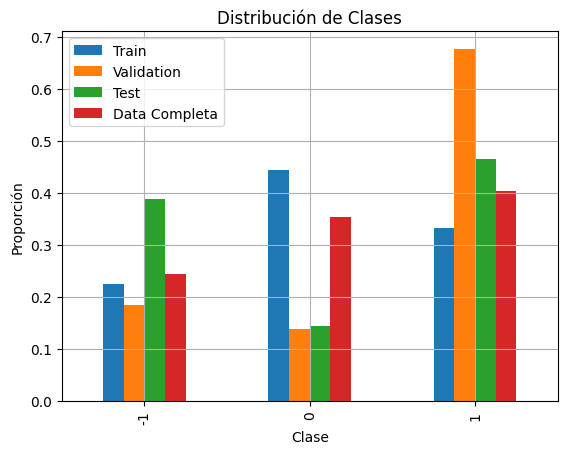

In [1858]:
# Convertimos a DataFrame para facilitar la visualización

final_distribution = df_sliding_window['target_trend'].value_counts(normalize=True)
train_distribution = pd.Series(training_set['target_trend']).value_counts(normalize=True)
validation_distribution = pd.Series(validation_set['target_trend']).value_counts(normalize=True)
test_distribution = pd.Series(test_set['target_trend']).value_counts(normalize=True)

# Comparar visualmente
df = pd.DataFrame({
    'Train': train_distribution,
    'Validation': validation_distribution,
    'Test': test_distribution,

    'Data Completa': final_distribution
    
}).fillna(0)

df.plot(kind='bar', title='Distribución de Clases')
plt.xlabel('Clase')
plt.ylabel('Proporción')
plt.grid(True)
plt.show()

In [1859]:
training_set.to_csv('../data/training_set.csv', index=False)
validation_set.to_csv('../data/validation_set.csv', index=False)
test_set.to_csv('../data/test_set.csv', index=False)